<a href="https://colab.research.google.com/github/danialebrat/Stock_Prediction/blob/main/Codes/Stock_train_BiLGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GRU, BatchNormalization, RepeatVector, TimeDistributed, Input
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
# preprocessed data
DATA_PATH = "/content/drive/MyDrive/Stock Prediction/Data.npy"

In [ ]:
# number of past records
n_past = 5

# number of future records that we want to predict
n_future = 1

In [ ]:
def load_data(data_path):
    
    # loading the data
    path = np.load(data_path)
    
    # the shape should be (N, 6, 1), which N is equal to number of segments
    # (4990, 6, 1)
    print(np.shape(path))

    return path

In [ ]:
def split_path(path):
    
    # spliting each segment
    # considering 5 record for the input
    # and 1 record for prediction
    
    X = []
    Y = []
    
    for i in path:
        
        X.append(i[0:n_past])
        Y.append(i[n_past:])
        
    
    return np.array(X), np.array(Y)

In [ ]:
def prepare_datasets(test_size, validation_size):
    
    # load data
    path = load_data(DATA_PATH)
    
    # spliting the test and train
    train, test = train_test_split(path , test_size=test_size)

    # spliting x_train(contains 5 records) and y_train(contains 1 records)    
    x_train, y_train = split_path(train)
    
    # spliting x_test(contains 5 records) and y_test(contains 1 records)
    x_test, y_test = split_path(test)
    
    # spliting x_validation and y_validation
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_size)
   

    return x_train, x_validation, x_test, y_train, y_validation, y_test

In [ ]:
def plot_history(history):
    
    """ plot accuracy/loss for training/validation set as a function of the epochs"""

    plt.plot(history.history["loss"], label="train error")
    plt.plot(history.history["val_loss"], label="validation error")
    plt.ylabel("Error")
    plt.xlabel("Epoch")
    plt.legend(loc="upper right")

    plt.savefig('Accuracy eval.png', dpi=100, bbox_inches='tight')
    plt.show()

In [ ]:
def build_model(input_shape):


    """
    The model uses an autoencoder architechture.
    encoder : 3 layers of BiLSTM and 1 layer of BiGRU
    RepeatVector: number of records we want to predict
    decoder: 3 layers of BiGRU
    output: A dense layer with one neuron (number of predictions)

    """

    # build network topology
    Autoencoder = Sequential()
    
    
    Autoencoder.add(Bidirectional(LSTM(128, input_shape=input_shape, return_sequences=True), input_shape=input_shape))
    Autoencoder.add(BatchNormalization())

    Autoencoder.add(Bidirectional(LSTM(64, return_sequences=True)))
    Autoencoder.add(BatchNormalization())

    Autoencoder.add(Bidirectional(LSTM(32, return_sequences=True)))
    Autoencoder.add(BatchNormalization())

    Autoencoder.add(Bidirectional(GRU(16)))
    Autoencoder.add(BatchNormalization())
    
    Autoencoder.add(RepeatVector(n = n_future))

    Autoencoder.add(Bidirectional(GRU(32, return_sequences=True)))
    Autoencoder.add(BatchNormalization())

    Autoencoder.add(Bidirectional(GRU(64, return_sequences=True)))
    Autoencoder.add(BatchNormalization())

    Autoencoder.add(Bidirectional(GRU(128, return_sequences=True)))
    Autoencoder.add(BatchNormalization())

    # dense layer
    Autoencoder.add(TimeDistributed(Dense(input_shape[1] , activation='relu')))

    return Autoencoder

(4990, 6, 1)
(4503, 5, 1)
(4503, 1, 1)
(237, 5, 1)
(237, 1, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_28 (Bidirecti  (None, 5, 256)           133120    
 onal)                                                           
                                                                 
 batch_normalization_28 (Bat  (None, 5, 256)           1024      
 chNormalization)                                                
                                                                 
 bidirectional_29 (Bidirecti  (None, 5, 128)           164352    
 onal)                                                           
                                                                 
 batch_normalization_29 (Bat  (None, 5, 128)           512       
 chNormalization)                                                
                                                         

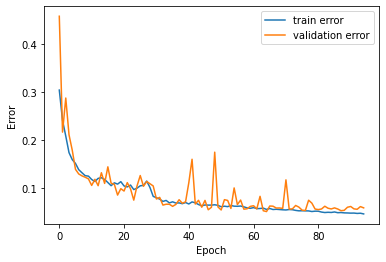

8/8 - 0s - loss: 0.0560 - mean_squared_error: 0.0560 - 66ms/epoch - 8ms/step

Test Accuracy :  0.05595193803310394


In [ ]:
if __name__ == "__main__":
    
    # get train, validation , test splits
    x_train, x_validation, x_test, y_train, y_validation, y_test = prepare_datasets(0.05, 0.05)
    
    # (4503, 5, 1)
    print(x_train.shape)
    # (4503, 1, 1)
    print(y_train.shape)
    # (237, 5, 1)
    print(x_validation.shape)
    # (237, 1, 1)
    print(y_validation.shape)

    # saving test dataset to evaluate the model
    np.save("x_test_stock", x_test)
    np.save("y_test_stock", y_test)

    # create network
    input_shape = (x_train.shape[1], x_train.shape[2])
    
    model = build_model(input_shape)

    # compile model
    optimizer = Adam(learning_rate=0.0007)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[metrics.MeanSquaredError()])

    # checkpoint: saving the model at each epoch if the val_mean_squared_error increases
    checkpoint_callback = ModelCheckpoint('Stock_model.h5', monitor='val_mean_squared_error', verbose=1,
                                          save_best_only=True, mode='min')
    
    # EarlyStopping if the model could not improve after 30 epochs
    es = EarlyStopping(monitor='val_mean_squared_error', mode='min', verbose=1, patience=30)

    # reducing the learning rate if the model could not improve after 7 epochs
    reducelr_callback = ReduceLROnPlateau(
        monitor='val_mean_squared_error', factor=0.7, patience=7, min_delta=0.00001,
        verbose=1
    )

    callbacks_list = [checkpoint_callback, reducelr_callback, es]

    model.summary()

    # train model
    history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=32, epochs=100,
                        callbacks=callbacks_list)

    # plot accuracy
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print("\nTest Accuracy : ", test_acc)

